# 05: QAOA (Quantum Approximate Optimization Algorithm)
    
   This exercise will guide you along the following steps:
   
   + What is MaxCut problem
   + Defining the cost function for MaxCut
   + Converting the cost function to quantum Hamiltonian describing energy landscape
   + Building QAOA ansatz using qiskit
   + Determining the parameters of the QAOA circuit with classical optimizer
   + Result readout

In this notebook, we need the basic qiskit methods we have used in earlier notebooks. As QAOA is an iterative hybrid algorithm, we also need a classical tool for minimizing a function. For this we use `scipy.optimize.minimize`. In addition, we use `matplotlib` for plotting results and `networkx` for drawing graphs.

We import all necessary methods into the following cell

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import networkx as nx

## In this hands-on exercise, we will solve the MaxCut problem with QAOA. 


### I) Preparing a graph

First, we generate a graph that will be the testbed for our algorithm.

To generate a graph, we define `nodes` and `edges`, and store them in the dictionary named `graph` 

In [2]:
nodes = [0, 1, 2, 3]
edges = [(0,1), (1,2), (2,3), (0,3)]

graph = {'nodes': nodes, 'edges':edges}

We can draw our graph using `networkx` library 

Graph with 4 nodes and 4 edges


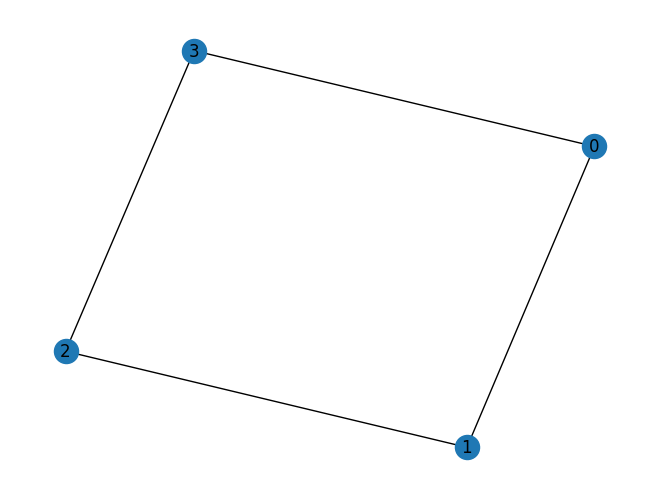

In [3]:
# Initialize graph. Add nodes and edges
G = nx.Graph()
G.add_nodes_from(graph['nodes'])
G.add_edges_from(graph['edges'])

# Set the layout. With fixed seed, the layout is always the same
pos=nx.spring_layout(G, seed=0)

# Print information about the graph
print(G)

# Draw the graph
nx.draw(G, pos, with_labels=True)
ax = plt.gca()
plt.show()

### II) Problem formulation: MaxCut

MaxCut is a combinatorial optimization problem. The goal of solving the MaxCut problem is to find a cut that divides the vertices of a graph into two complementary sets while maximizing the number of edges between the sets.
We can formulate the MaxCut problem in terms of the **cost function** $C$, which describes the goal of having connected vertices belonging to different partitions using the logical operators called exclusive-OR (XOR).

**Step 1: Classical cost function**
 
We denote the exclusive-OR operator as $\wedge$ (In Python, bitwise XOR is represented by `^`). For example, given binary numbers $A,B \in \{0,1\}$.
\begin{align*}
A \wedge B = 
\begin{cases}
    1,              & \text{if } A \neq B \\
    0,              & \text{if } A=B 
\end{cases}
\end{align*}

We can use these kinds of boolean clauses to formulate our **cost function** $C$. To do this, we state that we have two partitions, which we label 0-partition and 1-partition. We assign variable $v_i \in \{ 0,1 \}$, that states in which partition vertex number $i$ is located. Now, if we have an edge $(i,j)$, the associated pair of variables $(v_i, v_j)$ has XOR operation
\begin{align*}
v_i \wedge v_j = 
\begin{cases}
    1,              & \text{if } v_i \neq v_j \quad \text{i.e vertices belong in different partitions} \\
    0,              & \text{if } v_i =v_j     \quad \text{i.e vertices belong in same partition}
\end{cases}
\end{align*}
The cost function $C$ is a sum of these operations, where each term corresponds to one edge in the graph. The cost function achieves maximum when the number of cut edges is as large as possible.
\begin{equation*}
C = \sum_{(i,j) \in \text{edges} } v_i \wedge v_j
\end{equation*}

**Example:** If a graph, where $v_i$ represents $i^\text{th}$ vertex, has a set of edges $\{(0, 1)$, $(1, 2)$, $(2, 3)$, $(0, 3)\}$, the cost function is
\begin{equation*}
C = v_0 \wedge v_1 + v_1 \wedge v_2 + v_2 \wedge v_3 + v_0 \wedge v_3
\end{equation*}
The maximum value of this cost function is 4, which means none of the adjacent vertices belong to the same partition, ie. $v_0=v_2=0$ and $v_1=v_3=1$.
On the other hand, the minimum value is 0, in case all of them belong to the same partition.

The next step is where binary numbers come into the picture. In a graph of $N$ vertices, a single binary number $v=v_0v_1v_2v_3... v_i...v_N$, where $v_i$ is for $i^\text{th}$ vertex, can tell for all vertices whether they are in 0-partition or 1-partition.
Basically, we can write the cost function as a sum
\begin{equation*}
C = \sum_{\alpha=1}^{m} C_\alpha(v), 
\qquad \text{where} \qquad  C_\alpha(v) = 
\begin{cases}
    1,              & \text{if vertices in } \alpha^\text{th} \text{ edge belong in different partitions} \\
    0,              & \text{if vertices in } \alpha^\text{th} \text{ edge belong in same partition}
\end{cases}
\end{equation*}
Since the binary number $v=v_0v_1v_2v_3... v_i...v_N$ tells us exactly in which of the two partitions all the vertices in the graph belong, it also tells us how to cut the graph to achieve such a partition. The binary number that maximizes the cost function (the number of edges between the sets), thus solves the problem.

**Step 2: Mapping to quantum Hamiltonian** 

We now need a way to convert our cost function to something we can evaluate with a quantum computer. To do this, we need to remind ourselves of the following components
\begin{equation*}
|0\rangle = 
    \begin{bmatrix}
    1\\
    0
    \end{bmatrix} 
\qquad 
|1\rangle = 
    \begin{bmatrix}
    0\\
    1
    \end{bmatrix} 
\qquad 
Z = 
    \begin{bmatrix}
    1 & 0\\
    0 & -1
    \end{bmatrix}  
\end{equation*}
We can then start by writing our qubit register:
\begin{equation*}
|v \rangle = |v_0v_1v_2v_3... v_i...v_N \rangle, \qquad \text{where} \quad |v_i\rangle \in \{|0\rangle, |1\rangle \}
\end{equation*}

Remember how the Pauli $Z_i$ matrix operates on a qubit register: 
\begin{align*}
Z_i |v_0v_1v_2v_3... v_i...v_N \rangle = 
\begin{cases}
    +|v_0v_1v_2v_3... v_i...v_N \rangle,              & \text{if } v_i = 0 \\
    -|v_0v_1v_2v_3... v_i...v_N \rangle,              & \text{if } v_i = 1
\end{cases}
\end{align*}
This means that we can calculate the $Z_iZ_j$ expectation value as:
\begin{equation*}
\langle v|Z_iZ_j|v\rangle = 
\begin{cases}
    +1,              & \text{if } v_i = v_j \\
    -1,              & \text{if } v_i \neq v_j
\end{cases}
\end{equation*}

We can thus convert the cost function into energy operator or *Hamiltonian*:
\begin{equation*}
H = \frac{1}{2} \sum_{i,j} \big( 1- Z_i Z_j \big)
\end{equation*}
To see its resemblance to the cost function, we calculate the expectation value
\begin{equation*}
\langle v|H|v\rangle = \frac{1}{2} \sum_{i,j} \big(1- \langle v | Z_i Z_j |v \rangle \big) = \sum_{i,j} v_i \wedge v_j
\end{equation*}
This is exactly how we defined our cost function. But how does this help us to find the maximal cut? 

By minimizing the energy of the system (finding the smallest expectation value for the Hamiltonian), we can, with a high probability, find the system in a state $|v\rangle = |v_0v_1v_2v_3... v_i...v_N \rangle$, where the binary sequence $v_0v_1v_2v_3... v_i...v_N$ corresponds to the maximum cut!

**Step 3: Python implementation of cost function** 

Below we implement functions for calculating the expectation value of Hamiltonian for some particular graph given the results for measured states. We will need these later when we process the measurements from our quantum job.

In [4]:
# Utility function for calculating the (negative) value of cost function for given partition
def maxcut_cost(bitstring, graph):
    value = 0

    # Qiskit return states (binaries) in reversed order
    bitstring = bitstring[::-1]

    for i, j in graph['edges']:
        if bitstring[i] != bitstring[j]:                # If vertices are in different partitions
            value += (-1)                               # Minimizing negative cost maximizes the cost function
    return value

# This function calculates the expectation value from the measured results
def get_expval(counts, graph):
    exp_value = 0
    cost = 0
    total_shots = 0
    
    for bitstring, count in counts.items():
        cost += maxcut_cost(bitstring, graph) * count   # Calculate <|Z_i Z_j|>
        total_shots += count                            # Total shots by summing all the counts
    exp_value = cost/total_shots                        # Divide by total shots
    return exp_value

### III) Building the ansatz (Quantum part)

We now proceed to construct the quantum circuit for solving the MaxCut problem. The circuit makes use of parametric rotation gates, and the goal is to find parameters that result in the minimum energy for the system.

**Step 1:** Apply Hadamard gates to bring a system to equal superposition of all possible states
\begin{equation*}
H^{\otimes n} |00...0\rangle = \frac{|0\rangle_0 + |0\rangle_0}{\sqrt{2}} \frac{|0\rangle_1 + |0\rangle_1}{\sqrt{2}} ... \frac{|0\rangle_n + |0\rangle_n}{\sqrt{2}}
\end{equation*}

**Step 2:** We apply a layer consisting of two unitary operations mimicking the natural time evolution of the system Hamiltonian:
\begin{alignat*}{2}
& U_C(\gamma_l) = \prod_{ (a,b) \in \text{ edges}} e^{-i \gamma_l(1 - Z_j Z_k)/2} \qquad    && \textbf{Cost hamiltonian: } \text{Combination of  parameterized Z-rotations and CNOT-gates} \\
& U_B(\beta_l) = \prod_{ j \in \text{ vertices}} e^{-i X_j} \qquad                          && \textbf{Mixer hamiltonian: } \text{Parameterized X-rotations}
\end{alignat*}
Here, $U_C(\gamma_l)$ creates the state corresponding to the Hamiltonian. The role of $U_B(\beta_l)$ is to mix the state, which is important if our initial state happens to be the eigenstate of the Hamiltonian. 
The goal is to find parameters $\gamma_l$ and $\beta_l$ that minimize the cost Hamiltonian.

**Step 3:** By adding more layers to the circuit, (repeating the previous step), we can increase the accuracy of the algorithm. The parameter `layers` dictates the number of layers in our circuit. Parameters for each layer, $\gamma_l$ and $\beta_l$, are stored in lists  `gammas` and `betas`

In [5]:
def Build_QAOA(graph, gammas, betas, layers):
    # Allocate as many qubits as we have edges in the graph
    num_qubits = len(graph['nodes'])
    qc = QuantumCircuit(num_qubits, num_qubits)

    # Equal superposition of all possible states
    qc.h(range(num_qubits))

    # Cost Hamiltonian
    for i in range(layers):
        for ab in graph['edges']:
            qc.barrier()
            qc.cx(ab[0], ab[1])
            qc.rz(0.5*gammas[i], ab[1])
            qc.cx(ab[0], ab[1])
            
        # Mixer Hamiltonian
        qc.barrier()    # Add barrier for nicer visualization
        qc.rx(betas[i], range(num_qubits))
        
    # Measure all qubits
    qc.measure(range(num_qubits), range(num_qubits))
    return qc

We can visualize the circuit to see what we are dealing with. Below, you can try to change the angles and amount of layers to see what the circuit looks like. Remember to put to parameters as many angles as there are layers.

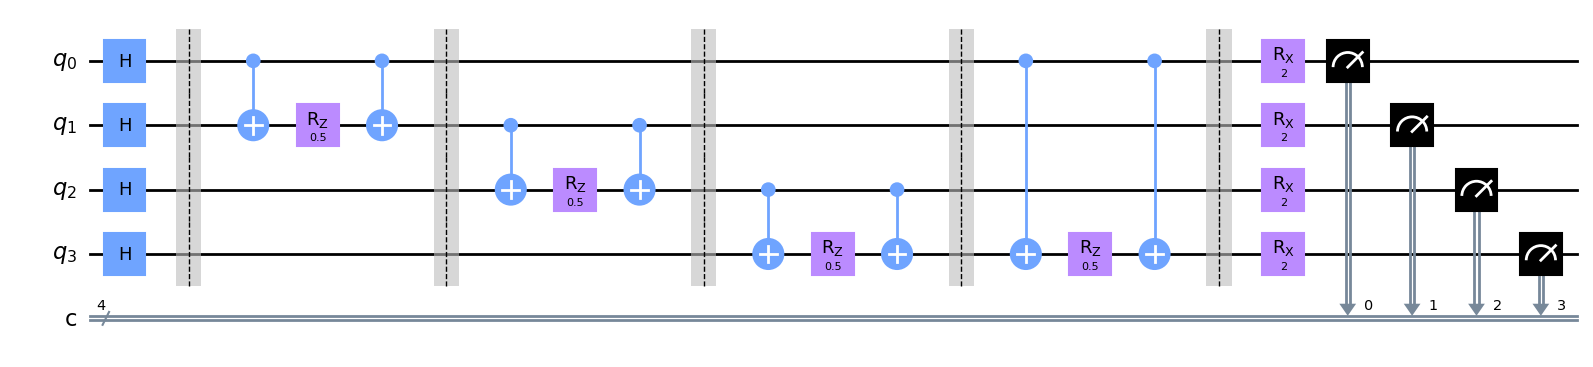

In [6]:
QAOA_circuit = Build_QAOA(graph, gammas = [1.0], betas=[2.0] , layers=1)
QAOA_circuit.draw('mpl', style='clifford')

Let's now try to run the circuit. We start with the ideal `Aer` simulator

In [7]:
backend_simulator = Aer.get_backend('statevector_simulator')

The most measured state represents the cut, and by calculating the expectation value, we can estimate the corresponding cost function

Hamiltonian expection value: -2.634
The most measured state: 1010


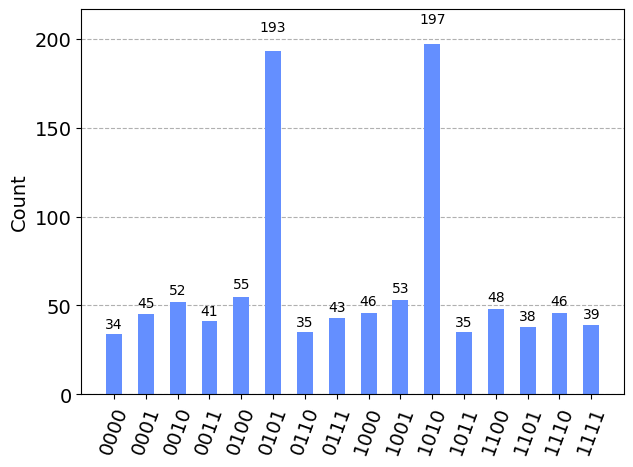

In [8]:
QAOA_counts = backend_simulator.run(QAOA_circuit, shots=1000).result().get_counts()
H_expval = get_expval(QAOA_counts, graph)

print(f"Hamiltonian expection value: {H_expval}")
print(f"The most measured state: {max(QAOA_counts, key=QAOA_counts.get)}")
plot_histogram(QAOA_counts)

We saw that our initial choice of parameters does not always yield the correct solution for MaxCut. We need a way to optimize the circuit parameters such that we get a correct result.

### IV) Optimizing the circuit parameters (Classical part)


The next step of QAOA is to implement and run the loop that will optimize the parameters $\gamma_l$ and $\beta_l$. If the circuit has multiple layers, we will have arrays with elements $\gamma_0,\gamma_1,\gamma_2...$ and $\beta_0,\beta_1,\beta_2...$. 

To perform the optimization, we use a minimizer because we want to find the circuit parameters that give the state with the least energy.

First, we need to construct a Python function, which we minimize. This function `run_QAOA` takes input parameters to be optimized as a concatenated list. It then constructs the circuit, runs it, calculates, and returns the expectation value.

To easily pass other parameters; `graph`, `backend`, `shots`, and `layers`, we use nested functions. 

In [9]:
expval_list = []    # We save all the expections values to plot them later

# Outer function
def get_QAOA_func(graph, backend, shots, layers):
    expval_list.clear()

    # Inner function, this we want to optimize
    def run_QAOA(angles):

        # Gat parameters are concantenated lists
        gammas = angles[:layers]
        betas = angles[layers:]

        # Build circuit
        qc = Build_QAOA(graph, gammas, betas, layers)

        # Transpile and run
        qc_transpiled = transpile(qc, backend)
        counts = backend.run(qc_transpiled, shots=shots).result().get_counts()
        
        # Calculate expectation value and save it
        expval = get_expval(counts, graph)
        expval_list.append(expval)
        return expval
    
    return run_QAOA

Now that we have our function, we need to set up a classical optimizer. We choose `scipy.optimize.minimize` and use the COBYLA method. For good results, we need to set a small enough tolerance and do a sufficient amount of iterations. We also need initial guesses for parameters, which we pass to the optimizer.

Below we implement a function for the optimization process.

In [10]:
def optimize_QAOA(graph, backend, shots, iterations, layers, method):

    # Get the function we will optimize, which is "run_QAOA", returned by "get_QAOA_func"
    func = get_QAOA_func(graph=graph, backend=backend, shots=shots, layers=layers)

    # Initial parameters
    gamma_0 = 3.147
    beta_0 = 3.147
    x0 = [gamma_0 for i in range(layers)] + [beta_0 for i in range(layers)]

    # Minimize the function using scipy minimizer
    results = minimize(fun=func, x0=x0, method=method, tol=1e-2, options={"maxiter":iterations})

    return results

We can now perform the optimization and print the results. Let's do this for one layer.

When successful, our optimizer returns the parameters for angles that give results for minimum energy.

Importantly, we can now check whether the optimization was successful i.e. whether the final energy result converges to a specific value. We do this by plotting all the values from `expval_list` as a function of optimizer iterations


  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.9916
       x: [ 4.765e+00  3.955e+00]
    nfev: 22
   maxcv: 0.0 

Minimum energy: -2.9916
Optimal gamma: [4.76471862]
Optimal beta: [3.95476688]


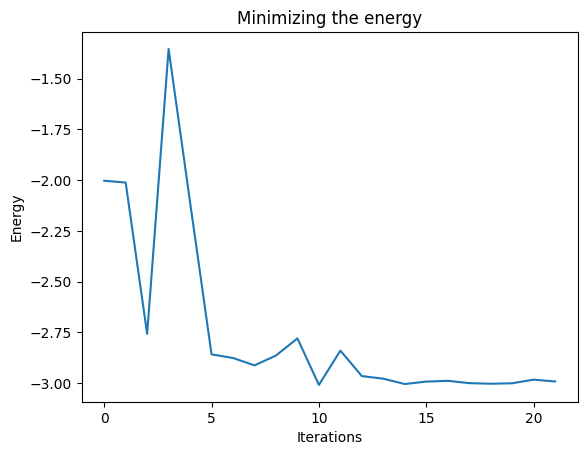

In [11]:
# Perform optimization and get the results
result = optimize_QAOA(graph, backend_simulator, shots=10000, iterations=150, layers=1, method='COBYLA')

# We can access the information about the optimization process and print it
minimum_energy = result.fun
optimal_gammas = result.x[:1]
optimal_betas = result.x[1:]

print(f"\n {result} \n")
print(f"Minimum energy: {minimum_energy}")
print(f"Optimal gamma: {optimal_gammas}")
print(f"Optimal beta: {optimal_betas}")

# Visualize energy
plt.plot(list(range(len(expval_list))), expval_list)
plt.title("Minimizing the energy")
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.show()

### V) Retrieving the maximum cut
Remember that our goal in MaxCut was to partition the vertices (represented by qubits) into two subgraphs such that the number of cut edges is maximized. 

Qubits belonging to different subgraphs will have opposite measurement outcomes. We find this information by measuring our circuit on a computational basis.

With our optimized parameters `optimal_gammas` and `optimal_betas`, we can run QAOA ansatz once more and retrieve an optimal statevector.


-------------------------------
The most probable solutions is
1010


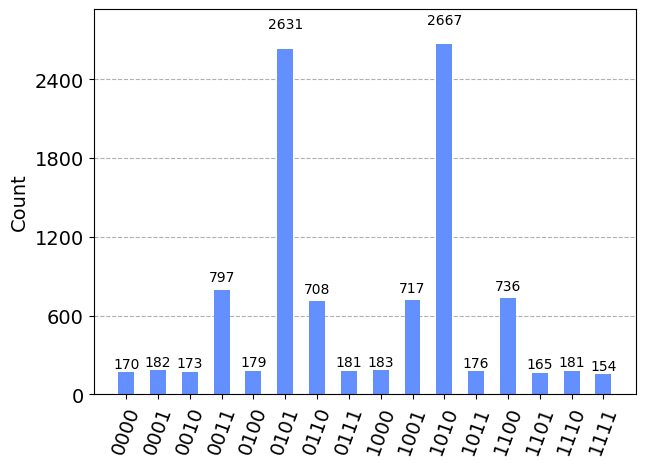

In [12]:
QAOA_optimal = Build_QAOA(graph=graph, gammas=optimal_gammas, betas=optimal_betas, layers=1)
QAOA_optimal_transpiled = transpile(QAOA_optimal, backend_simulator)
result_optimal = backend_simulator.run(QAOA_optimal_transpiled, shots=10000).result()
counts_optimal = result_optimal.get_counts()

most_probable_solution = max(counts_optimal, key=counts_optimal.get) # find the key i.e. state that has maximum probability
print("-------------------------------")
print("The most probable solutions is")
print(most_probable_solution)

plot_histogram(counts_optimal)

Now the result, represented by the most probable state, should be correct.

We can print the nodes in both subgraphs

In [13]:
## We need to extract the indices of the 0 and 1 partitions

# Reverse qiskit style counts
most_probable_solution = most_probable_solution[::-1]

print(f"Solution configuration: \n{most_probable_solution}\n")

indices_0 = [i for i, value in enumerate(most_probable_solution) if value == '0'] # build array holding the indices of 0's in the solution confiquration
print(f"The nodes in the first subgraph: \n{indices_0} \n")

indices_1 = [i for i, value in enumerate(most_probable_solution) if value == '1'] # build array holding the indices of 1's in the solution confiquration
print(f"The nodes in the second subgraph: \n{indices_1}")

Solution configuration: 
0101

The nodes in the first subgraph: 
[0, 2] 

The nodes in the second subgraph: 
[1, 3]


Let's finally create a visualization of our solution to the MaxCut problem.

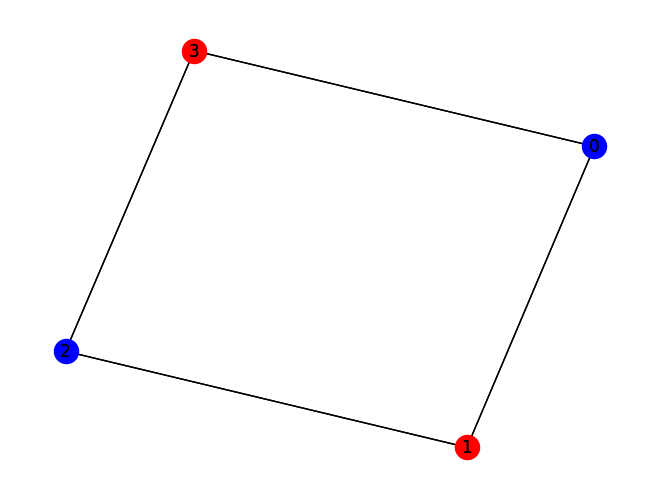

In [14]:
## Here we visualize the solution of the MaxCut problem. 

nx.draw(G,                # the nodes of '0'-partition will be colored blue  
                 pos=pos, 
                 with_labels=True,
                 nodelist=indices_0, 
                 node_color='blue')

nx.draw(G,                # the nodes of '1'-partition will be colored red
                 pos=pos, 
                 with_labels=True,
                 nodelist=indices_1, 
                 node_color='red')
 
ax = plt.gca()
plt.show()

# Extra:

## Exercise 1: Adding more layers

Increasing the number of layers to the QAOA circuit increases the accuracy of the algorithm. 


  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9984
       x: [ 3.378e+00  2.829e+00  1.717e+00  2.535e+00  4.523e+00
            1.987e+00]
    nfev: 59
   maxcv: 0.0 

Minimum energy: -3.9984
Optimal gamma: [3.37795477 2.82859996 1.71653019]
Optimal beta: [2.53473265 4.522701   1.98650444]


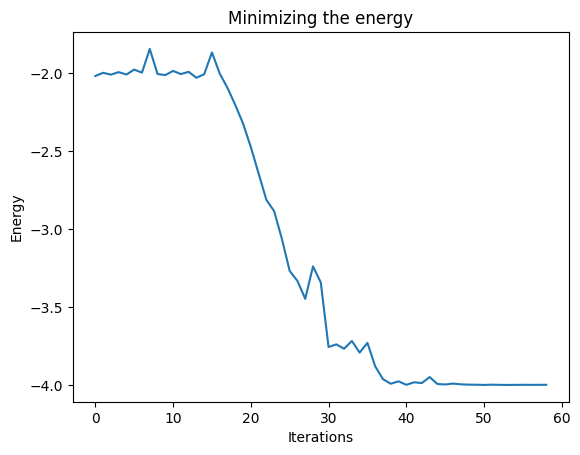

In [15]:
# You can change the parameters to see how it affects the result
num_layers = 3      # Layers in QAOA circuit

# Perform optimization and get the results
result_1 = optimize_QAOA(graph, backend_simulator, shots=10000, iterations=250, layers=num_layers, method='COBYLA')

# We can access the information about the optimization process and print it
minimum_energy_1 = result_1.fun
optimal_gammas_1 = result_1.x[:num_layers]
optimal_betas_1 = result_1.x[num_layers:]

print(f"\n {result_1} \n")
print(f"Minimum energy: {minimum_energy_1}")
print(f"Optimal gamma: {optimal_gammas_1}")
print(f"Optimal beta: {optimal_betas_1}")

plt.plot(list(range(len(expval_list))), expval_list)
plt.title("Minimizing the energy")
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.show()

-------------------------------
The most probable solutions is
0101


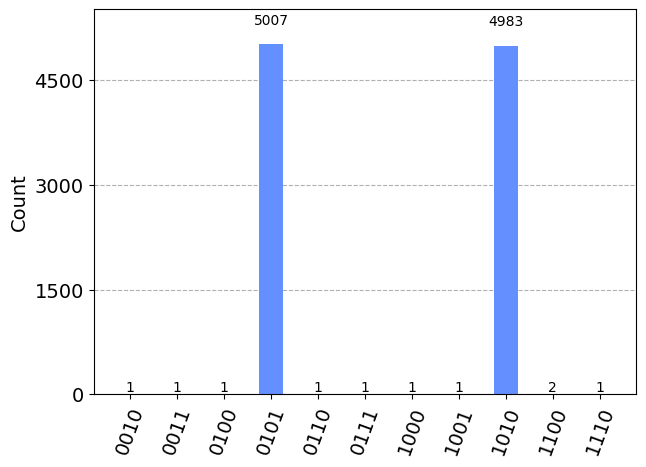

In [17]:
QAOA_optimal_1 = Build_QAOA(graph=graph, gammas=optimal_gammas_1, betas=optimal_betas_1, layers=num_layers)
counts_optimal_1 = backend_simulator.run(QAOA_optimal_1, shots=10000).result().get_counts()

most_probable_solution_1 = max(counts_optimal_1, key=counts_optimal_1.get) # find the key i.e. state that has maximum probability
print("-------------------------------")
print("The most probable solutions is")
print(most_probable_solution_1)

plot_histogram(counts_optimal_1)

Solution configuration: 
1010

The nodes in the first subgraph: 
[1, 3] 

The nodes in the second subgraph: 
[0, 2]


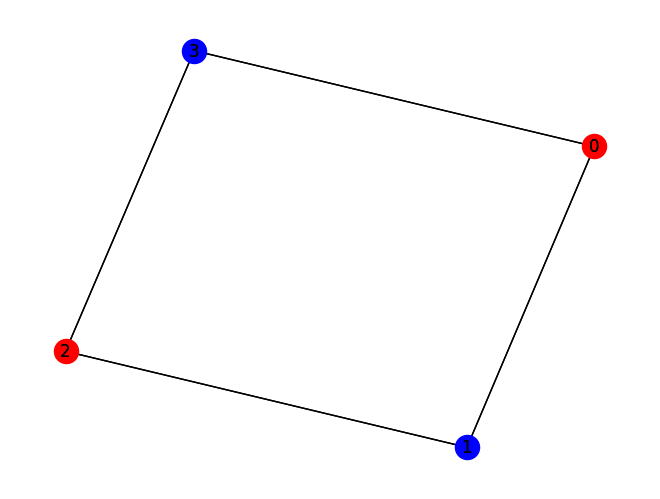

In [18]:
## We need to extract the indices of the 0 and 1 partitions

# Reverse qiskit style counts
most_probable_solution_1 = most_probable_solution_1[::-1]

print(f"Solution configuration: \n{most_probable_solution_1}\n")

indices_0 = [i for i, value in enumerate(most_probable_solution_1) if value == '0'] # build array holding the indices of 0's in the solution confiquration
print(f"The nodes in the first subgraph: \n{indices_0} \n")

indices_1 = [i for i, value in enumerate(most_probable_solution_1) if value == '1'] # build array holding the indices of 1's in the solution confiquration
print(f"The nodes in the second subgraph: \n{indices_1}")


## Here we visualize the solution of the MaxCut problem. 

nx.draw(G,                # the nodes of '0'-partition will be colored blue  
                 pos=pos, 
                 with_labels=True,
                 nodelist=indices_0, 
                 node_color='blue')

nx.draw(G,                # the nodes of '1'-partition will be colored red
                 pos=pos, 
                 with_labels=True,
                 nodelist=indices_1, 
                 node_color='red')
 
ax = plt.gca()
plt.show()

## Exercise 2: Different classical optimizers

Select optimization methods from the some of the available ones:

        - 'Nelder-Mead'
        - 'Powell'      
        - 'CG'          
        - 'BFGS'          
        - 'L-BFGS-B'    
        - 'TNC'         
        - 'COBYLA'      
        - 'SLSQP'       
        - 'trust-constr'
and pass them as parameters. See how this affects the minimization of energy. You will see that some methods work better than others.

In [ ]:
# You can change the parameters to see how it affects the result
num_layers_2 = 1      # Layers in QAOA circuit

# Try different optimizers by uncommenting
#-------------------------------------
#optimizer_method = 'Nelder-Mead'
optimizer_method = 'Powell'
#optimizer_method = 'CG'
#optimizer_method = 'BFGS'
#optimizer_method = 'L-BFGS-B'
#optimizer_method = 'TNC'
#optimizer_method = 'COBYLA'
#optimizer_method = 'SLSQP'
#optimizer_method = 'trust-constr'
#-------------------------------------

# Perform optimization and get the results
result_2 = optimize_QAOA(graph, backend_simulator, shots=1000, iterations=250, layers=num_layers_2, method=optimizer_method)

# We can access the information about the optimization process and print it
minimum_energy_2 = result_2.fun
optimal_gammas_2 = result_2.x[:num_layers_2]
optimal_betas_2 = result_2.x[num_layers_2:]

print(f"\n {result_2} \n")
print(f"Minimum energy: {minimum_energy_2}")
print(f"Optimal gamma: {optimal_gammas_2}")
print(f"Optimal beta: {optimal_betas_2}")

plt.plot(list(range(len(expval_list))), expval_list)
plt.title("Minimizing the energy")
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.show()

In [ ]:
QAOA_optimal_2 = Build_QAOA(graph=graph, gammas=optimal_gammas_2, betas=optimal_betas_2, layers=num_layers_2)
counts_optimal_2 = backend_simulator.run(QAOA_optimal_2, shots=1000).result().get_counts()

most_probable_solution_2 = max(counts_optimal_2, key=counts_optimal_2.get) # find the key i.e. state that has maximum probability
print("-------------------------------")
print("The most probable solutions is")
print(most_probable_solution_2)

plot_histogram(counts_optimal_2)

In [ ]:
## We need to extract the indices of the 0 and 1 partitions

# Reverse qiskit style counts
most_probable_solution_2 = most_probable_solution_2[::-1]

print(f"Solution configuration: \n{most_probable_solution_2}\n")

indices_0 = [i for i, value in enumerate(most_probable_solution_2) if value == '0'] # build array holding the indices of 0's in the solution confiquration
print(f"The nodes in the first subgraph: \n{indices_0} \n")

indices_1 = [i for i, value in enumerate(most_probable_solution_2) if value == '1'] # build array holding the indices of 1's in the solution confiquration
print(f"The nodes in the second subgraph: \n{indices_1}")


## Here we visualize the solution of the MaxCut problem. 

nx.draw(G,                # the nodes of '0'-partition will be colored blue  
                 pos=pos, 
                 with_labels=True,
                 nodelist=indices_0, 
                 node_color='blue')

nx.draw(G,                # the nodes of '1'-partition will be colored red
                 pos=pos, 
                 with_labels=True,
                 nodelist=indices_1, 
                 node_color='red')
 
ax = plt.gca()
plt.show()

## Takeaway

In this notebook, we have learned about:
   + What is MaxCut problem
   + Defining the cost function for MaxCut
   + Converting the cost function to quantum Hamiltonian describing energy landscape
   + Building QAOA ansatz using qiskit
   + Determining the parameters of the QAOA circuit with classical optimizer
   + Result readout

You can go back to the start and define your own graph to see how the algorithm works for different graphs.